# Major Project

### COMP8430 - Advanced Computer Vision and Action

#### Name: Mir Sadia Afrin
#### ID: 47965495

### Phase 2: Fine-tuning a Pretrained Model on a Fine-Grained Image Dataset

## Project Summary – Phase 2

In this continuation of our image classification project, we focused on fine-tuning two deep learning models — **ResNet50** and **Inception v3** — for fine-grained classification of cat breeds. The dataset consists of 23 carefully selected cat breeds, with each breed containing over 50 images, collected from diverse sources such as Google, the CFA official website, Instagram, and personal pet photos from friends and family.

All group members (Sadia, Subhana, and Abhi) contributed to the image collection process. We ensured variation in pose, angle, background, and lighting conditions to enrich the dataset. The dataset is organized into breed-wise folders, and a corresponding `labels.csv` file includes image paths, breed names, coat length, and personality traits.

The primary objective was to gain practical experience in **fine-tuning existing pretrained models**, understand the impact of different strategies, and evaluate performance improvements through **data augmentation**.

In Phase 2, we used two pretrained models — **ResNet50** and **Inception v3** — and fine-tuned them using our training and development sets. For each model, we experimented with::
- To **fine-tune ResNet50 and Inception v3** on our dataset by selectively unfreezing layers and applying learning rate scheduling.
- To apply **data augmentation techniques** (e.g., horizontal flip, rotation, brightness adjustment) to improve generalization.
- To **evaluate and compare** model performance using test accuracy, classification reports, confusion matrices, and visualizations of misclassified images.

Our results showed that ResNet50 slightly outperformed Inception v3 in accuracy, though both models showed strengths in different aspects of breed recognition. In future iterations, we aim to expand the dataset with additional images under varied lighting and environmental conditions, which could further enhance model robustness.

## Dataset Preparation

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights, Inception_V3_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Reading CSV file
df = pd.read_csv("sadia_labels.csv")

# Normalizing path strings
df["Path"] = df["Path"].str.replace("\\", "/", regex=False)  # Fix Windows backslashes
df["Path"] = df["Path"].apply(lambda p: p + ".jpg" if not p.lower().endswith(".jpg") else p)

# Using the corrected path directly
df["FullPath"] = df["Path"]

# Filtering valid image files
df["Exists"] = df["FullPath"].apply(os.path.exists)
df = df[df["Exists"]].reset_index(drop=True)

# Encoding class labels
class_names = sorted(df["Breed Name"].unique())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
df["Label"] = df["Breed Name"].map(class_to_idx)

# Showing result
print(f"Valid images found: {len(df)}")
print(f"Total classes: {len(class_names)}")
print(df[["Breed Name", "FullPath", "Label"]].head())

Valid images found: 438
Total classes: 23
   Breed Name                                 FullPath  Label
0  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_01.jpg      0
1  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_02.jpg      0
2  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_03.jpg      0
3  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_04.jpg      0
4  Abyssinian  Data/Sadia/Abyssinian/Abyssinian_05.jpg      0


## Dataset Split

In [4]:
#Splitting the Dataset

from sklearn.model_selection import train_test_split

# Split: 60% train, 10% val, 30% test
train_val_df, test_df = train_test_split(
    df, test_size=0.3, stratify=df["Label"], random_state=42
)
train_df, val_df = train_test_split(
    train_val_df, test_size=0.1/0.7, stratify=train_val_df["Label"], random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 262 | Val: 44 | Test: 132


##### Here, the collected dataset has been split into this ratio -
* Training set (60%) - 262 images,
* Validation set (10%) - 44 images and
* Testing set (30%) - 132 images.

## Dataset Class

In [5]:
#PyTorch Dataset Class

class CatBreedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = Image.open(row["FullPath"]).convert("RGB")
        label = row["Label"]
        if self.transform:
            image = self.transform(image)
        return image, label

## Data Augmentation & Transforms (With Augmentation for Train)

In [6]:
import torchvision.transforms as transforms

transform_resnet_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_resnet_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_incep_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
transform_incep_test = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

## Data Loaders

In [7]:
def get_dataloaders(transform_train, transform_test):
    return (
        DataLoader(CatBreedDataset(train_df, transform_train), batch_size=32, shuffle=True),
        DataLoader(CatBreedDataset(val_df, transform_test), batch_size=32),
        DataLoader(CatBreedDataset(test_df, transform_test), batch_size=32)
    )

## Fine-Tuned Model Setup

In [8]:
def setup_model(name, fine_tune_all=False):
    if name == "resnet":
        model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        for name, param in model.named_parameters():
            param.requires_grad = fine_tune_all or ("layer4" in name or "fc" in name)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))

    elif name == "inception":
        model = models.inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True)
        for name, param in model.named_parameters():
            param.requires_grad = fine_tune_all or ("Mixed_7c" in name or "fc" in name)
        model.fc = nn.Linear(model.fc.in_features, len(class_names))
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, len(class_names))

    return model.to(device)

## Training Function

In [9]:
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    is_inception = isinstance(model, models.Inception3)

    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            if is_inception and isinstance(outputs, tuple): outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        scheduler.step()
        val_acc = evaluate_model(model, val_loader, silent=True)
        print(f"Epoch {epoch+1}: Train Acc = {correct/total:.4f}, Val Acc = {val_acc:.4f}")

## Evaluation & Misclassification

In [10]:
def evaluate_model(model, loader, silent=False):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            if isinstance(outputs, tuple): outputs = outputs[0]
            preds = torch.argmax(outputs, 1)
            y_true += labels.cpu().tolist()
            y_pred += preds.cpu().tolist()
    if not silent:
        print(classification_report(y_true, y_pred, target_names=class_names))
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
        disp.plot(xticks_rotation=90, cmap='Blues')
        plt.title("Confusion Matrix")
        plt.show()
    return np.mean(np.array(y_true) == np.array(y_pred))

## Run ResNet50

Training ResNet50...
Epoch 1: Train Acc = 0.0802, Val Acc = 0.2273
Epoch 2: Train Acc = 0.3092, Val Acc = 0.4318
Epoch 3: Train Acc = 0.5916, Val Acc = 0.5909
Epoch 4: Train Acc = 0.7328, Val Acc = 0.6136
Epoch 5: Train Acc = 0.8130, Val Acc = 0.5909
Epoch 6: Train Acc = 0.8321, Val Acc = 0.6136
Epoch 7: Train Acc = 0.8511, Val Acc = 0.6136
Epoch 8: Train Acc = 0.8435, Val Acc = 0.6136
Epoch 9: Train Acc = 0.8740, Val Acc = 0.6364
Epoch 10: Train Acc = 0.8779, Val Acc = 0.6591

Evaluating ResNet50 on test set


/Users/mirayon/Documents/Softwares/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mirayon/Documents/Softwares/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mirayon/Documents/Softwares/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

                      precision    recall  f1-score   support

          Abyssinian       1.00      1.00      1.00         5
  American Shorthair       0.60      0.60      0.60         5
            Balinese       0.00      0.00      0.00         5
              Bengal       1.00      1.00      1.00         5
              Birman       1.00      0.60      0.75         5
   British Shorthair       1.00      0.80      0.89         5
             Burmese       0.80      0.80      0.80         5
         Cornish Rex       1.00      0.33      0.50         6
           Devon Rex       0.56      0.83      0.67         6
        Egyptian Mau       0.46      1.00      0.63         6
              Exotic       0.50      0.17      0.25         6
    Japanese Bobtail       0.75      0.60      0.67         5
      Maine Coon Cat       0.33      0.17      0.22         6
Norwegian Forest Cat       0.60      1.00      0.75         6
            Oriental       1.00      0.17      0.29         6
       

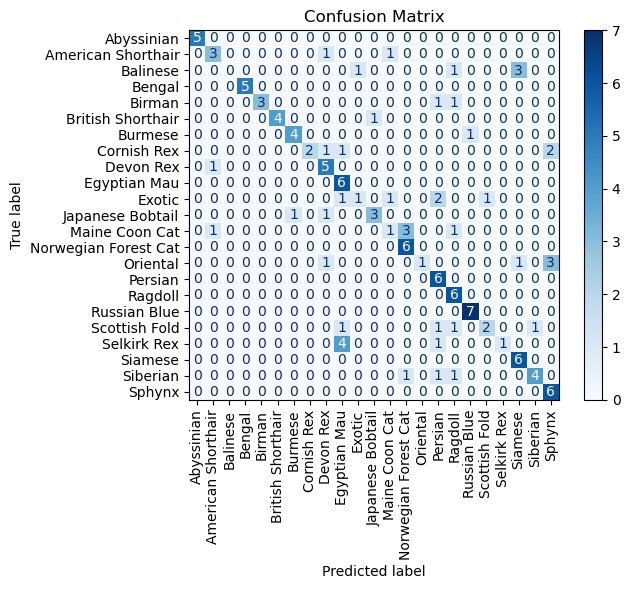

0.6590909090909091

In [11]:
train_loader, val_loader, test_loader = get_dataloaders(transform_resnet_train, transform_resnet_test)
print("Training ResNet50...")
model_resnet = setup_model("resnet")
train_model(model_resnet, train_loader, val_loader, epochs=10)
print("\nEvaluating ResNet50 on test set")
evaluate_model(model_resnet, test_loader)

## Run Inception v3

Training Inception v3...
Epoch 1: Train Acc = 0.0840, Val Acc = 0.2500
Epoch 2: Train Acc = 0.4084, Val Acc = 0.4545
Epoch 3: Train Acc = 0.5954, Val Acc = 0.5227
Epoch 4: Train Acc = 0.6947, Val Acc = 0.5909
Epoch 5: Train Acc = 0.7557, Val Acc = 0.5909
Epoch 6: Train Acc = 0.7328, Val Acc = 0.6136
Epoch 7: Train Acc = 0.7824, Val Acc = 0.5455
Epoch 8: Train Acc = 0.7977, Val Acc = 0.5909
Epoch 9: Train Acc = 0.8282, Val Acc = 0.5682
Epoch 10: Train Acc = 0.7901, Val Acc = 0.6136

Evaluating Inception v3 on test set
                      precision    recall  f1-score   support

          Abyssinian       1.00      0.80      0.89         5
  American Shorthair       0.60      0.60      0.60         5
            Balinese       1.00      0.20      0.33         5
              Bengal       0.83      1.00      0.91         5
              Birman       0.50      0.60      0.55         5
   British Shorthair       0.67      0.80      0.73         5
             Burmese       1.00      0.80 

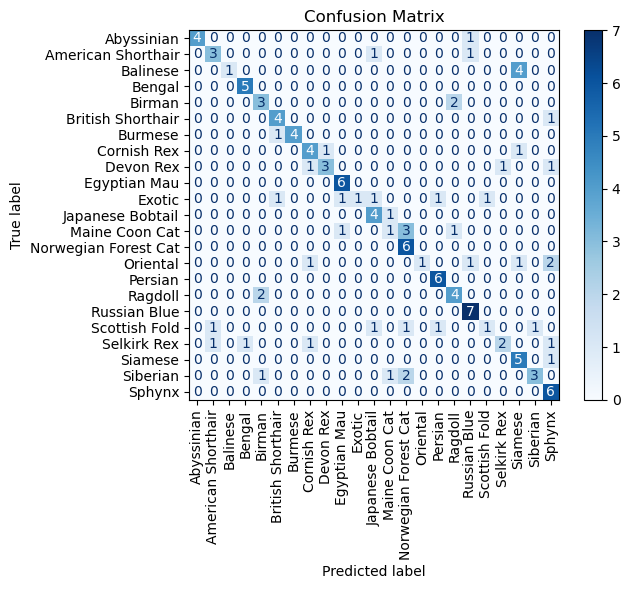

0.6363636363636364

In [12]:
train_loader, val_loader, test_loader = get_dataloaders(transform_incep_train, transform_incep_test)
print("Training Inception v3...")
model_incep = setup_model("inception")
train_model(model_incep, train_loader, val_loader, epochs=10)
print("\nEvaluating Inception v3 on test set")
evaluate_model(model_incep, test_loader)

## Model Evaluation &Comparison

### Test Accuracy Comparison

- **ResNet50 Test Accuracy:** 65.91%
- **Inception v3 Test Accuracy:** 63.64%

The fine-tuned ResNet50 model outperformed Inception v3 on the testing set by approximately 2.3%. Both models benefited from data augmentation and selective fine-tuning, but ResNet50 was more consistent across classes and showed slightly better generalization on this dataset. While Inception is a deeper network, it did not surpass ResNet in this task, likely due to the limited dataset size and high visual similarity among cat breeds. But it is very close to each other.

### Strengths and Weaknesses Analysis

#### ResNet50
- **Strengths:**
  - Faster training and inference compared to Inception
  - Performs well on common and distinct-looking breeds
  - More stable generalization across validation and test sets

- **Weaknesses:**
  - Struggles with very similar-looking breeds (e.g., American Shorthair vs Russian Blue)
  - May miss subtle differences in fur patterns or facial shapes

#### Inception v3
- **Strengths:**
  - Deeper network allows richer feature extraction
  - Better at capturing fine textures in some cases (e.g., fur detail, eyes)

- **Weaknesses:**
  - Slower to train and more memory-intensive
  - Slightly lower test accuracy than ResNet in this dataset
  - Overfitting risk due to dataset size and model depth

#### Insight:
ResNet50 was overall more efficient and robust in this task, whereas Inception v3 had potential for finer distinctions but didn’t outperform ResNet due to training constraints and dataset scale.

In [16]:
def visualize_misclassifications(model, loader, class_names, n=6):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple): outputs = outputs[0]
            preds = torch.argmax(outputs, 1)

            for i in range(len(labels)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), preds[i].item(), labels[i].item()))
                if len(misclassified) >= n:
                    break
            if len(misclassified) >= n:
                break

    # Plot in one row
    plt.figure(figsize=(3 * n, 4))
    for i, (img_tensor, pred, actual) in enumerate(misclassified):
        img = img_tensor.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # unnormalize
        img = np.clip(img, 0, 1)

        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"True: {class_names[actual]}\nPred: {class_names[pred]}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

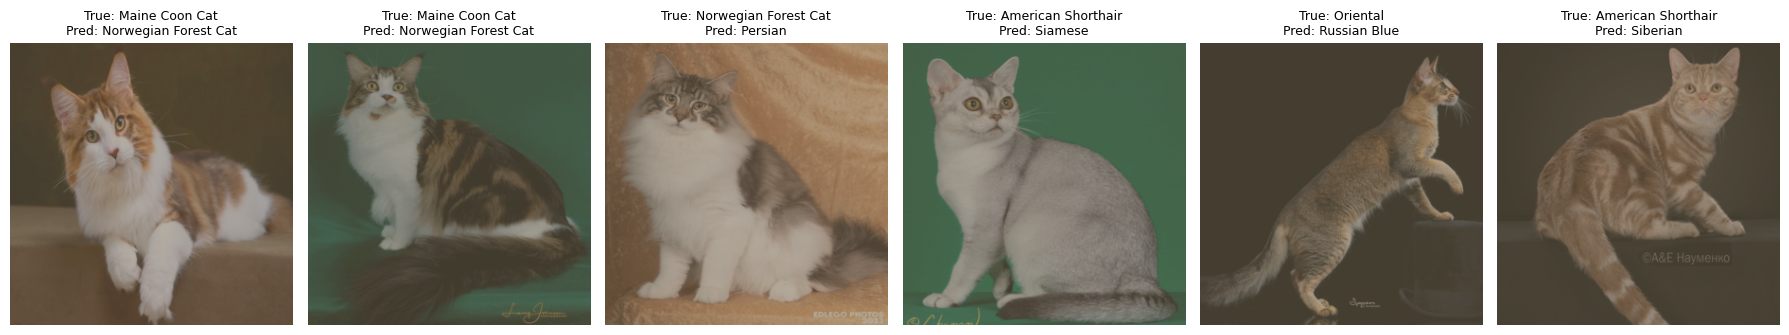

In [17]:
visualize_misclassifications(model_resnet, test_loader, class_names)

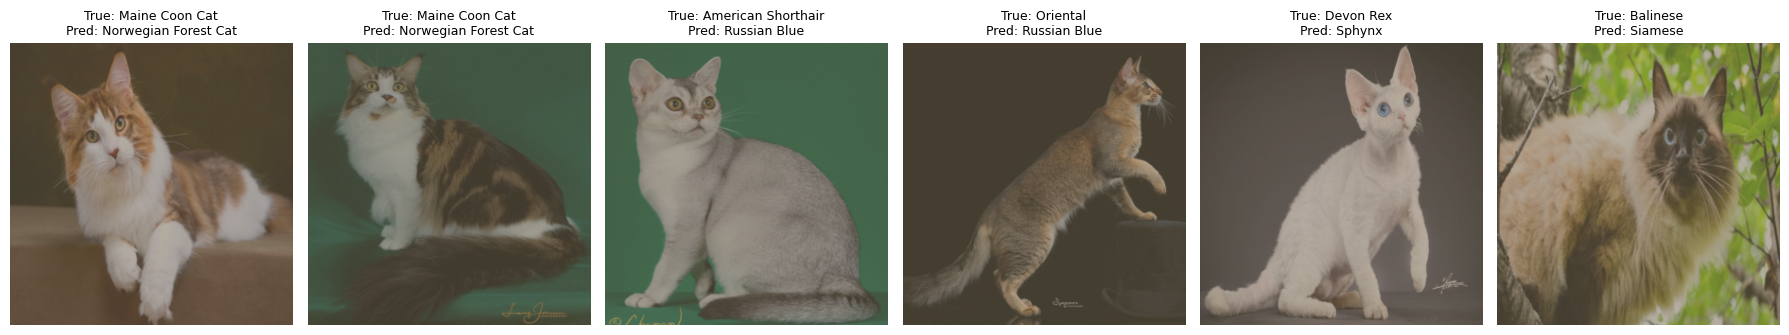

In [18]:
visualize_misclassifications(model_incep, test_loader, class_names)

## Misclassification Analysis

Both ResNet50 and Inception v3 misclassified several images due to challenges common in fine-grained classification:

### Common Patterns Observed:
- **Visually similar breeds**:
  - Maine Coon vs Norwegian Forest Cat
  - American Shorthair vs Russian Blue

- **Lighting issues**:
  - Dim or uneven lighting caused confusion in texture-based classification

- **Partial occlusion or side-angle views**:
  - When the cat’s face wasn’t fully visible, the models struggled to extract key features

### Model-Specific Observations:
- **ResNet50**:
  - More likely to make mistakes when breed markings were subtle
  - Performed better on well-lit, frontal images

- **Inception v3**:
  - Captured some fine fur textures better, but was more sensitive to background clutter
  - Struggled slightly more than ResNet with sharp pose variations

### Conclusion:
Misclassifications were primarily due to inter-class visual similarity and image quality. Both models benefited from augmentation but still had limitations with challenging examples.